In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data_path = "../data/train/"
test_data_path = "../data/test/"

train_data_files = ["AAPL", "BRK_B", "DVN","NVDA", "PCG", "ROST", "V", "VNQ"]
test_data_files = ["LOW", "TSLA"]

vis_path = "../visualizations/"

In [3]:
train_data_combined = None
test_data_combined = None

features = ["5_day", "market_cap_b", "open-open", "open-close", "Open", "rsi", "buy"]

for f in train_data_files:
	df = pd.read_csv(train_data_path + f + "_clean.csv", parse_dates=["Date"], index_col="Date")
	df = df[features]
	if train_data_combined is None:
		train_data_combined = df
	else:
		train_data_combined = pd.concat([train_data_combined, df])

for f in test_data_files:
	df = pd.read_csv(test_data_path + f + "_clean.csv", parse_dates=["Date"], index_col="Date")
	df = df[features]
	if test_data_combined is None:
		test_data_combined = df
	else:
		test_data_combined = pd.concat([test_data_combined, df])


train_x, train_y = train_data_combined.drop("buy", axis=1), train_data_combined["buy"]
test_x, test_y = test_data_combined.drop("buy", axis=1), test_data_combined["buy"]

display(len(train_x))
display(len(train_y))
display(train_y.value_counts())
test_y.value_counts()

17536

17536

1    9262
0    8274
Name: buy, dtype: int64

1    2383
0    2083
Name: buy, dtype: int64

In [5]:
model = RandomForestClassifier(criterion="log_loss")
model.fit(train_x, train_y)

pred = model.predict(test_x)
print(confusion_matrix(test_y, pred))
print("\n" + classification_report(test_y, pred))
model.score(test_x, test_y)

[[1232  851]
 [ 980 1403]]

              precision    recall  f1-score   support

           0       0.56      0.59      0.57      2083
           1       0.62      0.59      0.61      2383

    accuracy                           0.59      4466
   macro avg       0.59      0.59      0.59      4466
weighted avg       0.59      0.59      0.59      4466



0.5900134348410211

Testing stocks individually:

LOW:
--------
[[555 465]
 [461 752]]

              precision    recall  f1-score   support

           0       0.55      0.54      0.55      1020
           1       0.62      0.62      0.62      1213

    accuracy                           0.59      2233
   macro avg       0.58      0.58      0.58      2233
weighted avg       0.59      0.59      0.59      2233

0.5853112404836542

TSLA:
--------
[[677 386]
 [519 651]]

              precision    recall  f1-score   support

           0       0.57      0.64      0.60      1063
           1       0.63      0.56      0.59      1170

    accuracy                           0.59      2233
   macro avg       0.60      0.60      0.59      2233
weighted avg       0.60      0.59      0.59      2233

0.5947156291983878



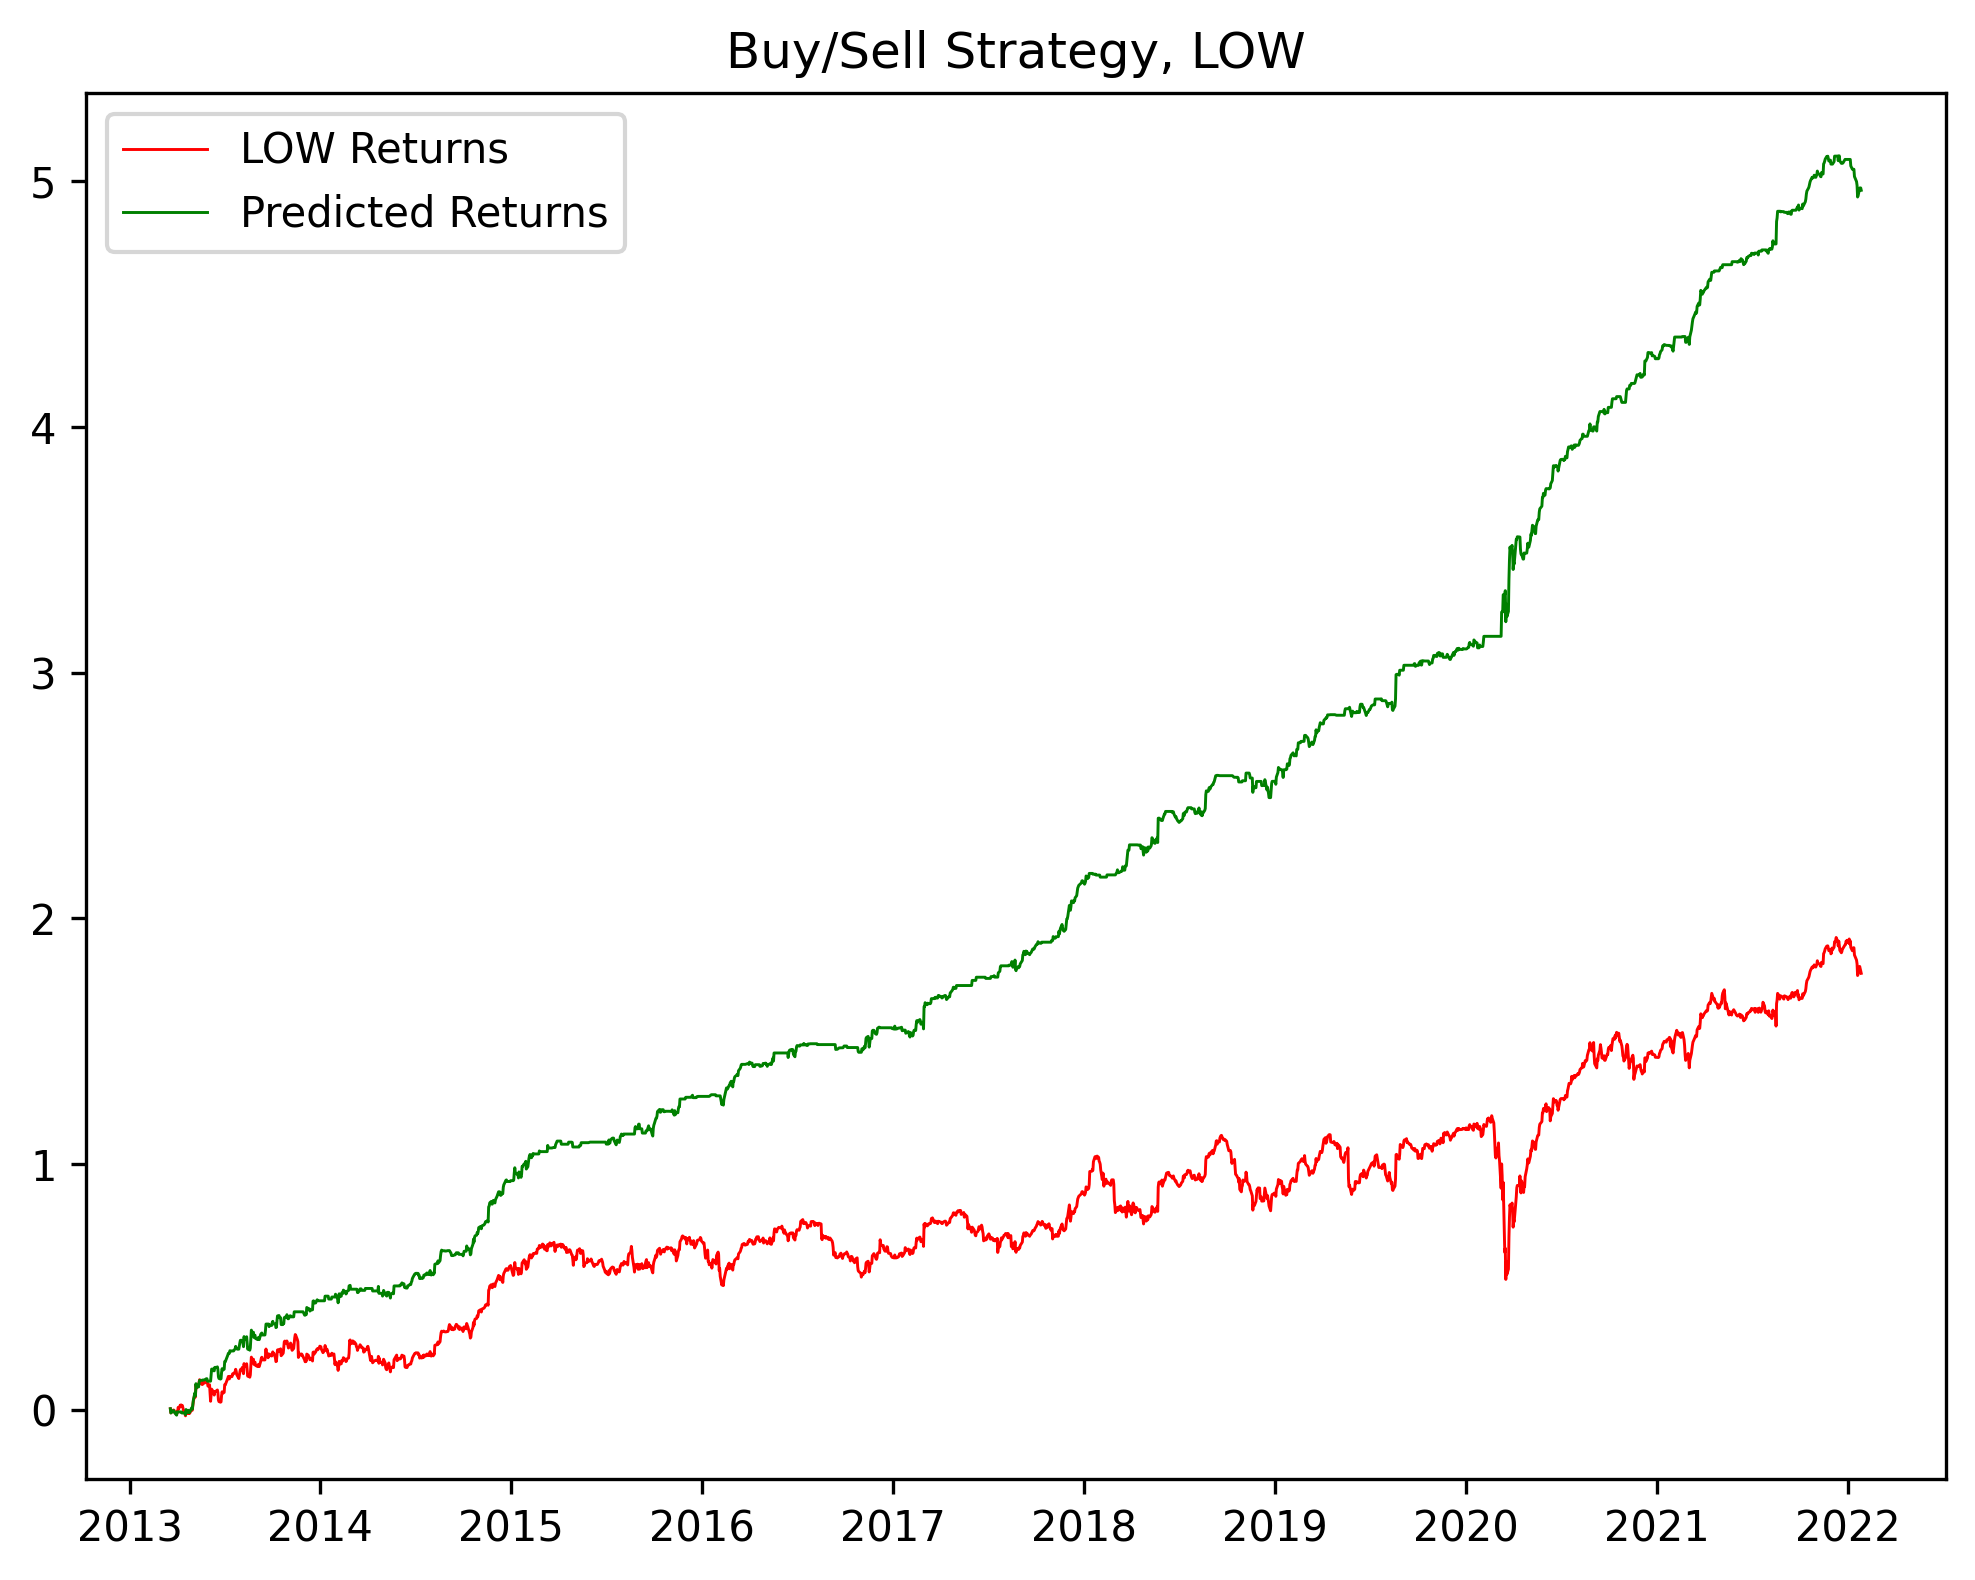

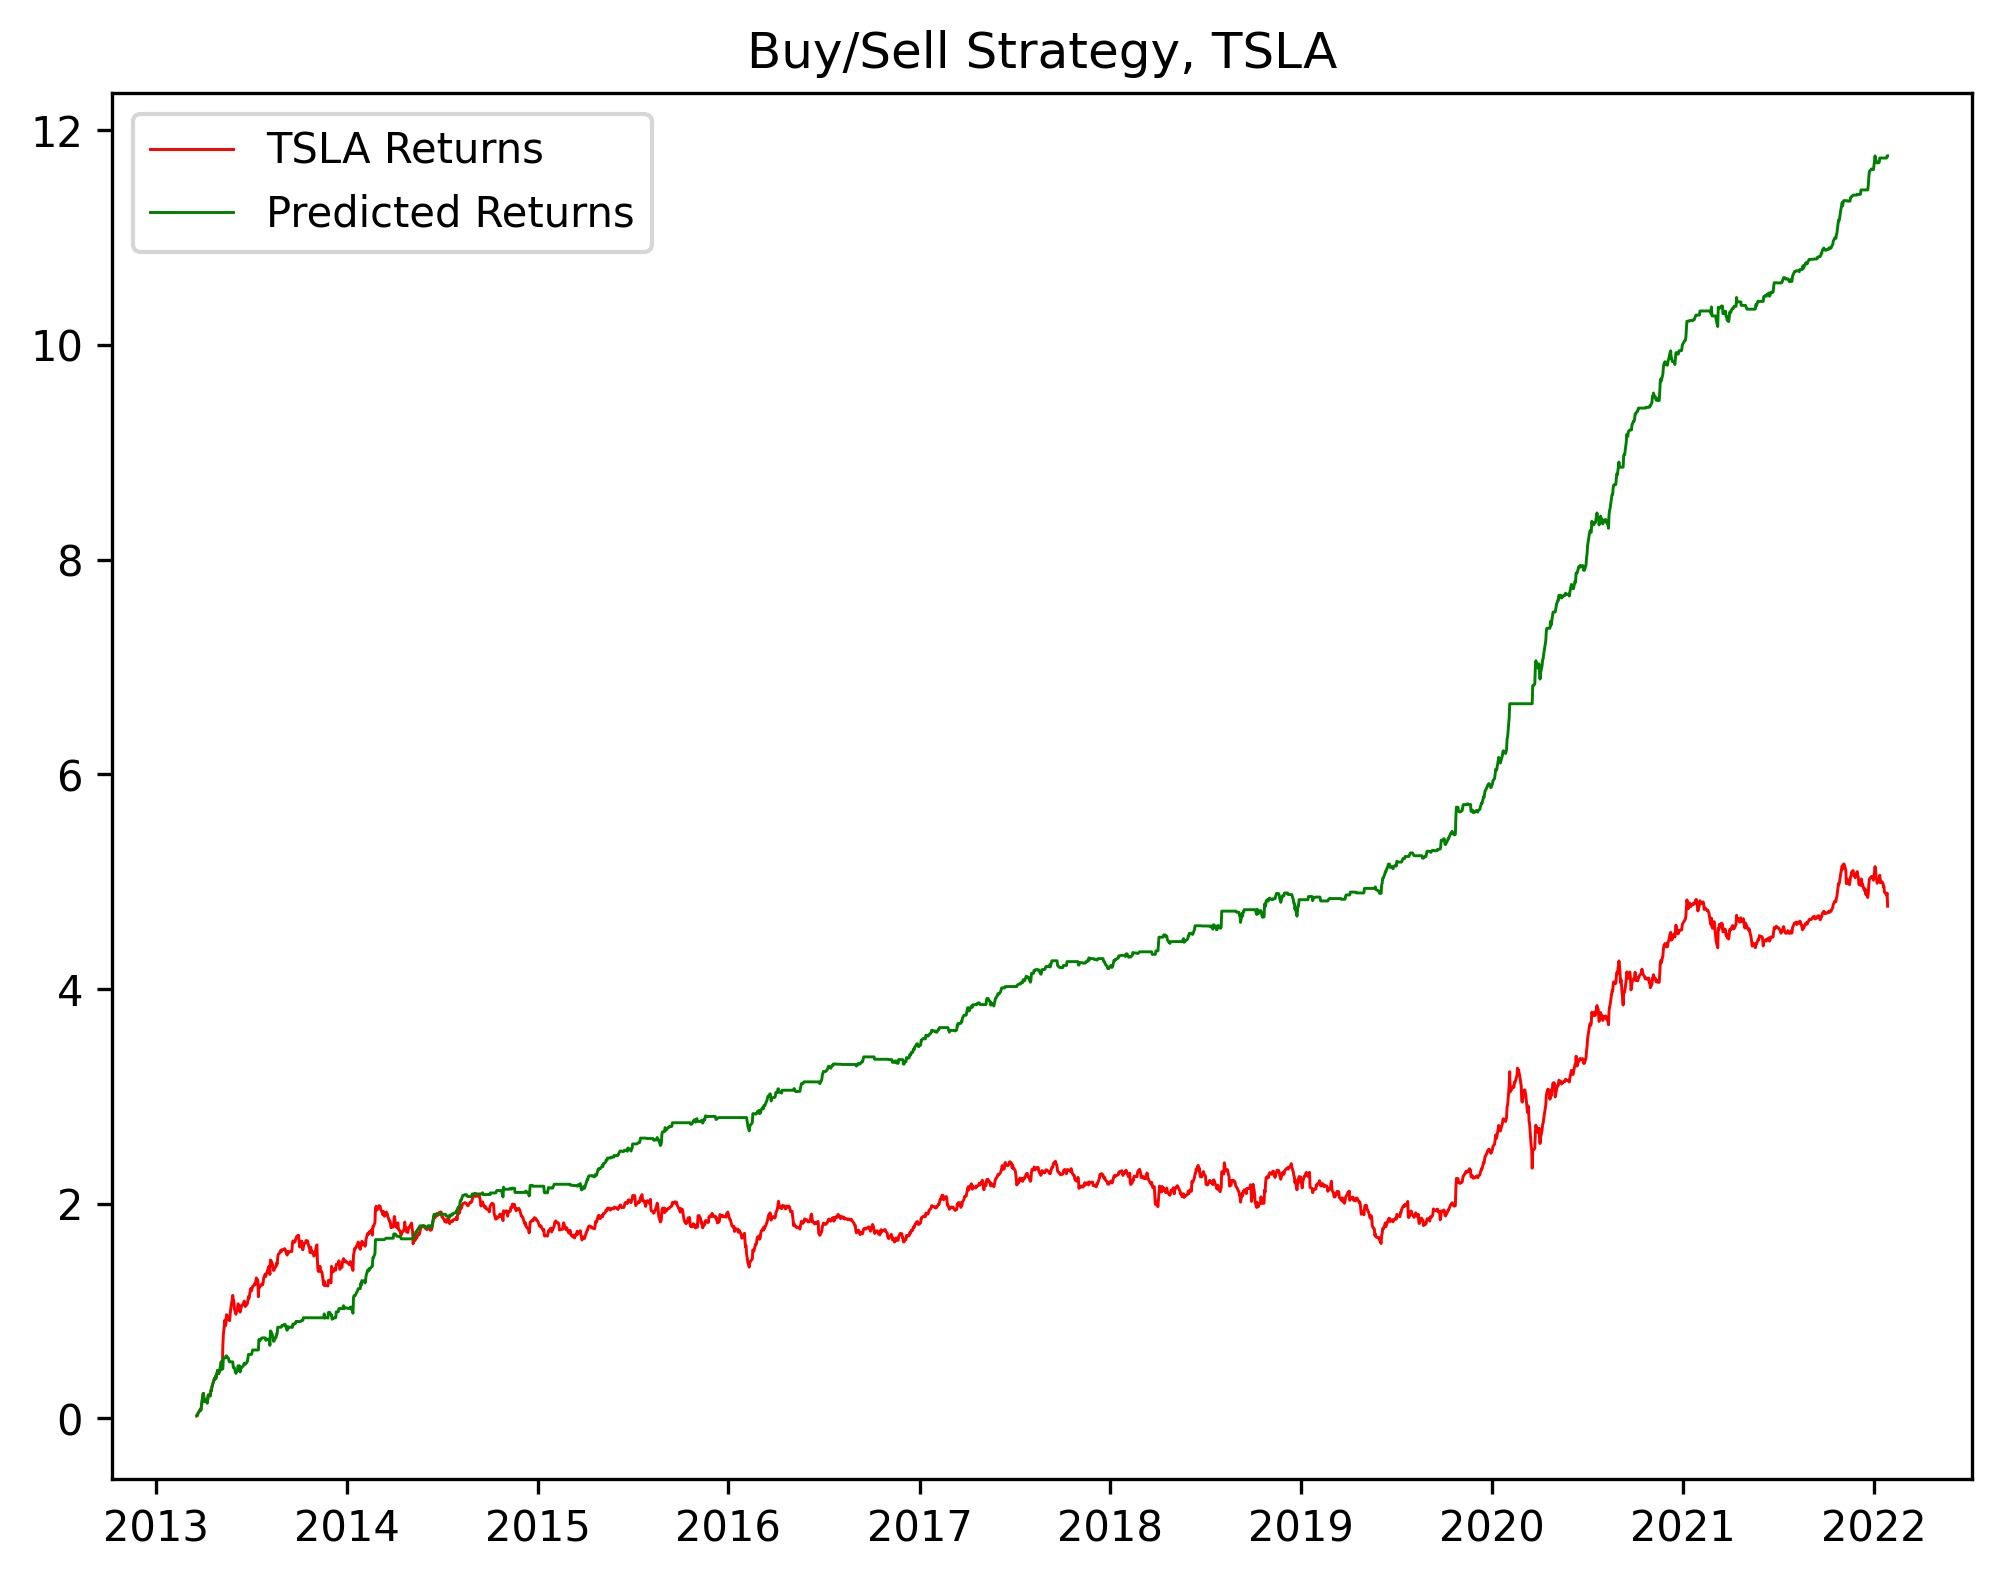

In [6]:
print("Testing stocks individually:\n")
for f in test_data_files:
	print(f"{f}:\n--------")
	df = pd.read_csv(test_data_path + f + "_clean.csv", parse_dates=["Date"], index_col="Date")
	df = df.iloc[::-1]
	returns = np.log(df['Close/Last']/df['Close/Last'].shift())
	cum_returns = np.cumsum(returns)

	split_x = df[features].drop(["buy"], axis=1)
	split_y = df["buy"]
	split_pred = model.predict(split_x)

	print(confusion_matrix(split_y, split_pred))
	print("\n" + classification_report(split_y, split_pred))
	print(model.score(split_x, split_y))
	print()

	df["pred"] = split_pred
	df["pred"].apply(lambda x: -1 if x == 0 else 1)

	predicted_returns = returns * df["pred"].shift()
	cum_pred_returns = np.cumsum(predicted_returns)

	plt.figure(figsize=(8,6), dpi=300)
	plt.plot(cum_returns, color='r',label = f'{f} Returns', linewidth=0.7)
	plt.plot(cum_pred_returns, color='g', label = 'Predicted Returns', linewidth=0.7)
	plt.title(f"Buy/Sell Strategy, {f}")
	plt.legend()
	plt.savefig(f"../results/{f}_random_forest.svg", bbox_inches="tight", format='svg')